#Module importieren

**numpy:** Ermöglicht das Rechnen mit Tensoren (zb: Matrizen und Vektoren)

**matplotlib:** Zum zeichnen von Graphen, Bildern, Diagrammen, ...

**tensorflow:** Eigentlich zum trainieren von neuronalen Netzen, wir nutzen das Modul aber nur zum Laden des MNIST-Datensatzes

In [1]:
%pip install -q numpy matplotlib tensorflow
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from random import randint

from dataclasses import dataclass #Build in Python Modul, dient lediglich der Struktur
from typing import Tuple,List #Typangaben (Haben keine Auswirkung auf das Programm, dient nur zur Übersicht)


[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


2025-05-19 10:03:25.036227: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747649008.492226     550 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747649008.575626     550 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747649008.902248     550 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747649008.902325     550 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747649008.902330     550 computation_placer.cc:177] computation placer alr

#Unser eigenes Machine Learning Framework
Im Folgendem werden wir unser eigenes Framework schreiben, mit welchem Machine Learning Modelle trainiert werden können. Unser Framework wird nach wenigen Minuten Training 80% des MNIST-Datensatzes (Handschrifterkennung) vorhersagen können

#Aktivierungsfunktionen


Zuerst unser "Grundgerüst". Hier wird der "ActivationFunction" Datentyp definiert. Eine Activationfunktion speichert zwei Python-Funktionen, die eigentliche Funktion und die Ableitung

In [2]:
@dataclass
class ActivationFunction:
    function:callable
    derivative:callable

Für unser Framework definieren wir nun Relu und Softmax als Aktivierungsfunktionen

In [3]:
#Relu
relu = ActivationFunction(lambda x: np.maximum(0, x),
                          lambda x: x>0)

_e_x = lambda x: np.exp(x - np.max(x, axis=1, keepdims=True))
_softf = lambda x: _e_x(x) / _e_x(x).sum(axis=1, keepdims=True)
softmax = ActivationFunction(_softf,
                             lambda x: _softf(x) * (1 - _softf(x)))

#Die einzelne Schicht
Ein Neuronales Netz besteht aus mehreren Schichten.
In unserem Framework speichert die Klasse Layer alle Daten, die man für die mit einer Schicht verbundenen Rechnungen benötigt. (Gewichte, Biases und Aktivierungsfunktion)
Des weiteren bietet die Klasse die Funktionen "feedForward" um die Neuronenwerte der nächsten Schicht zu berechnen, "getDerivatives" um die Ableitungen der Parameter im Bezug auf die Loss-Funktion zu berechnen und "sgd"(=stochastic gradient descent), um die errechneten Ableitungen zu verwenden um die Parameter an die Trainingsdaten anzupassen

In [4]:
class Layer:
    def __init__(self, nActualLayer:int, nNextLayer:int, activationFunction:ActivationFunction):
        #Gewichte und Biases mit Zufallszahlen füllen
        self.weightsForNext = np.random.uniform(-0.5,0.5,(nActualLayer, nNextLayer))
        self.biasesForNext = np.random.uniform(-0.5,0.5,(nNextLayer,))

        #Die Aktivierungsfunktion setzen und Werteaufnahmen als leere Arrays speichern
        self.activationFunction = activationFunction

        self.last_z = np.array([])
        self.last_values = np.array([])

    def feedForward(self, neurons:np.array, recording=False):
        "Berechnet eine Schichtausgabe aus einer übergebenen Eingabe"

        #z berechnen
        z = neurons @ self.weightsForNext + self.biasesForNext

        #Speichert die z-Werte und die Eingabe fürs Training
        if recording:
            self.last_z = z
            self.last_values = neurons

        #Ausgabe der Aktivierungsfunktion zurückgeben
        return self.activationFunction.function(z)

    def getDerivatives(self, outputDerivative:np.array) -> Tuple[np.array, np.array, np.array]:
        #Der Code wird nur ausgeführt, wenn die nötigen Werte aufgezeichnet wurden
        if not (len(self.last_z) and len(self.last_values)):
            raise ValueError("No records")

        #Faktor um Batch-Durchschnitt zu berechnen
        f =1/outputDerivative.shape[0]

        #Die Steigungen berechnen und zurückgeben
        z = outputDerivative * self.activationFunction.derivative(self.last_z)
        b = z.sum(axis=0) * f
        w = self.last_values.T @ z * f
        a = z @ self.weightsForNext.T
        return b,w,a

    def sgd(self, derivatives:np.array, learningRate:float) -> None:
        "Passt die Werte mit dem Stochastic-Descent-Optimizer an"

        self.biasesForNext -= derivatives[0] * learningRate
        self.weightsForNext -= derivatives[1] * learningRate

#Das Netz
Die Schichten dienen einem Neuronalem Netz. Die Klasse Network verwaltet dieses. Hierfür speichert die Klasse die einzelnen Schichten und bietet die Funktionen "feedForward" um Input-Daten durch das gesamte Netz zu geben und die Ausgabe zur Verfügung zu stellen, "loss", welche die Lossfunktion und dessen Ableitung fürs Training zur Verfügung stellt und "training", welche Eingabedaten und deren Labels verwendet um unser Netz zu trainieren.

In [5]:
class Network:
    def __init__(self, layers:List[Layer]):
        self._layers = layers

    def feedForward(self, inputs:np.array, recording=False):
        #Geht alle Schichten des Netzes von vorne nach hinten durch und setzt immer die Ausgaben einer Schicht in die nächste ein
        values = inputs
        for layer in self._layers:
            values = layer.feedForward(values, recording)

        #Gibt die Ausgaben der letzten Schicht zurück
        return values

    def mse_loss(outputs, labels):
        "Berechnet den MSE-Loss"

        loss = np.sum((labels - outputs) ** 2, axis=0)
        derivative =  (outputs-labels) * 2
        return loss, derivative

    def train(self, inputs:np.array, labels:np.array, learningRate=0.01) -> float:
        #Das Netz durchlaufen und fürs Training nötige Werte speichern lassen
        outputs = self.feedForward(inputs, True)

        derivatives = []

        #Loss errechnen
        loss, outputDerivative = Network.mse_loss(outputs, labels)

        #Netz von hinten nach vorne durchlaufen und die Steigungen in einer Liste speichern
        for layer in self._layers[::-1]:
            derivative = layer.getDerivatives(outputDerivative)
            outputDerivative = derivative[2]
            derivatives.append(derivative)

        #Das Netz von hinten nach vorne durchlaufen und die Steigungen nutzen um die Parameter anzupassen
        for layer, layerDerivatives in zip(self._layers[::-1], derivatives):
            layer.sgd(layerDerivatives, learningRate)

        #Den durchschnittlichen Loss des Batches zurückgeben
        return sum(loss)/outputs.shape[0]

# Das fertige Framework testen

## Laden der Daten
Unser Framework ist nun fertig! Zum Testen nutzen wir das MNIST-Dataset, welches wir im Folgendem runterladen

In [6]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

#Wertspanne liegt bei 0-255, indem wir durch 255 teilen, normalisieren wir zu 0-1
train_images= train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

Roh können wir die Daten noch nicht verwenden. Wir müssen die Bilder flatten, also zweidimensionale Bilder in eindimensionale Vektoren umwandeln, damit unser Netz die Daten einlesen kann

In [7]:
train_images = np.array([x.flatten() for x in train_images])
test_images = np.array([x.flatten() for x in test_images])

Schauen wir uns doch mal die Labels fürs Training an

In [8]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

So können wir das nicht vergleichen. Unser Neuronales Netz gibt zehn Werte aus. Jedes Output-Neuron steht für eine Zahl. Das Neuron mit dem höchsten Wert bestimmt die Zahl, die unser Netz wählt. Damit unser Netz die Labels fürs training nutzen kann, wandeln wir sie wie folgt um:

0 = [1,0,0,0,0,0,0,0,0,0]

1 = [0,1,0,0,0,0,0,0,0,0]

2 = [0,0,1,0,0,0,0,0,0,0]

usw

In [9]:
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=10)

#Definieren eines Netzes
Unser Netz besitzt einen Hiddenlayer mit 10 Neuronen und der Relu-Aktivierungsfunktion. Für die Output-Schicht nutzen wir die Softmax-Funktion um Wahrscheinlichkeiten für die 10 Ziffern zu definieren (Wie sicher ist sich das Modell, dass es die repräsentative Ziffer ist?)

Die Bilder sind 28px*28px groß, daher gibt es 784 Inputs/Pixel

In [10]:
n = Network([
    Layer(784, 16, relu), # 1. Schicht mit 784 Eingabepixel und 16 Ausgaben für die nächste Hidden Layer
    Layer(16,16, relu), #2. Schicht nimmt die 16 Ausgaben der 1. Schicht an und gibt 16 für die letzte layer aus
    Layer(16, 10, softmax) #3. Schicht nimmt die 16 Ausgaben der 2. Schicht und gibt 10 Wahrscheinlichkeiten (softmax-Funktion) aus (Für die 10 Ziffern 0-9)
])

##Training
Schon können wir das Netz trainieren. Die Losses alle Epochen speichern wir in eine Liste, damit wir uns den Verlauf anschauen können.

Alle 10 Epochen wird der aktuelle Loss ausgegeben

In [11]:
epochs = 150

losses = []
for epoch in range(1,epochs+1):
    loss =n.train(train_images, train_labels, 0.5)
    losses.append(loss)
    if (epoch)%10==0:
        print(f"epoch:{epoch}, loss:{loss}")

epoch:10, loss:0.9090706117455868
epoch:20, loss:0.8792199052092518
epoch:30, loss:0.8433070600236707
epoch:40, loss:0.7952942317265451
epoch:50, loss:0.7275478136526996
epoch:60, loss:0.6793746981509751
epoch:70, loss:0.6453599431786103
epoch:80, loss:0.6155342892412412
epoch:90, loss:0.5852734257995905
epoch:100, loss:0.550562144333948
epoch:110, loss:0.5070316593626228
epoch:120, loss:0.46003793476403065
epoch:130, loss:0.43367297893372514
epoch:140, loss:0.40788315019850213
epoch:150, loss:0.38594894722197964


Der Graph zeigt die Änderung des Losses während des Trainings
Aufgrund unseres simplen SGD-Optimizers kann es zu kurzfristigen Erhöhungen des Losses kommen


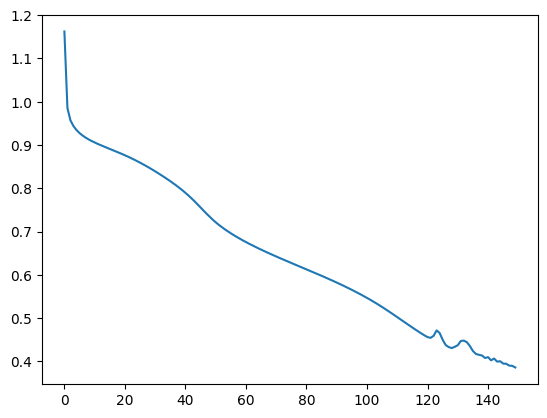

In [12]:
plt.plot(losses)
plt.show()

Wie viel Prozent der nicht fürs training verwendeten Bilder erkennt unser Netz?

In [13]:
outputs = n.feedForward(test_images)
p = int(np.count_nonzero(np.argmax(outputs, axis=1) == test_labels)/100)
print(f"Percentage: {p}")

Percentage: 73


Führe diese Zelle aus, um das Neuronale Netz ein zufälliges Bild erkennen zu lassen

5


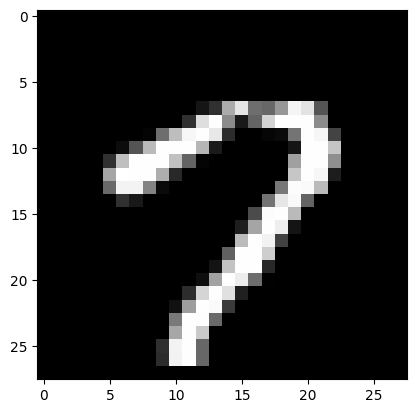

In [14]:
test_image = test_images[randint(0,len(test_images))]
result = n.feedForward(test_image.reshape(1,784))
print(np.argmax(result))

_ = plt.imshow(test_image.reshape(28,28), cmap='gray', vmin=0, vmax=1)